# Testing a New Emission Model
Use the `fiasco` library to revamp emission model used for synthesizing active region emission.

In [17]:
import logging
import pytest
import numpy as np
from scipy.interpolate import interp1d,splev
from scipy.ndimage import map_coordinates
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from astropy.utils.console import ProgressBar
import fiasco
import cloudpickle
import plasmapy

import synthesizAR
from synthesizAR.atomic import Ion,Element,EmissionModel
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

What does the emission model need to do?
- Hold information about each ion
- Store and retrieve emissivity data for each ion
- Accept a grid of temperature and density points over which the emissivity is calculated
- Accept a number of wavelengths for which the wavelength resolved emission is saved

What does a minimal ion object/dictionary need to store?
- element name
- ion name
- path to emissivity database
- temperature grid
- density grid
- wavelength grid

In [ ]:
class Element(fiasco.Element):
    def __getitem__(self, value):
        if type(value) is int:
            value = self.ions[value]
        return Ion(value, self.temperature, hdf5_path=self.hdf5_dbase_root)

In [ ]:
class EmissionModel(fiasco.IonCollection):
    """
    Model for how atomic data is used to calculate emission from 
    coronal plasma.
    """
    
    @u.quantity_input
    def __init__(self, density: u.cm**(-3), *args,**kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = self[0].temperature
        self.density = density
        self.resolved_wavelengths = kwargs.get('resolved_wavelengths',{})
        
    def interpolate_to_mesh_indices(self, loop):
        """
        Return interpolated loop indices to the temperature and density meshes defined for
        the atomic data. For use with `~scipy.ndimage.map_coordinates`.
        """
        nots_itemperature = splrep(self.temperature.value, np.arange(self.temperature.shape[0]))
        nots_idensity = splrep(self.density.value, np.arange(self.density.shape[0]))
        itemperature = splev(np.ravel(loop.electron_temperature.value), nots_itemperature)
        idensity = splev(np.ravel(loop.density.value), nots_idensity)

        return itemperature, idensity
        
    def calculate_emissivity(self, savefile, **kwargs):
        """
        Calculate and store emissivity for every ion in the model
        """
        self.emissivity_savefile = savefile
        with h5py.File(savefile,'w') as hf:
            with ProgressBar(len(self._ion_list), ipython_widget=kwargs.get('notebook', True)) as progress:
                for ion in self:
                    wavelength,emissivity = ion.emissivity(self.density, include_energy=False)
                    if wavelength is None or emissivity is None:
                        continue
                    emissivity = emissivity[:,:,np.argsort(wavelength)]
                    wavelength = np.sort(wavelength)
                    grp = hf.create_group(ion.ion_name)
                    ds = grp.create_dataset('wavelength',data=wavelength.value)
                    ds.attrs['units'] = wavelength.unit.to_string()
                    ds = grp.create_dataset('emissivity', data=emissivity.data)
                    ds.attrs['units'] = emissivity.unit.to_string()
                    progress.update()
    
    def get_emissivity(self, ion):
        with h5py.File(self.emissivity_savefile,'r') as hf:
            if ion.ion_name not in hf:
                return None,None
            ds = hf['/'.join([ion.ion_name,'wavelength'])]
            wavelength = u.Quantity(ds,ds.attrs['units'])
            ds = hf['/'.join([ion.ion_name,'emissivity'])]
            emissivity = u.Quantity(ds,ds.attrs['units'])
            
        return wavelength,emissivity

In [ ]:
temperature = 10**(np.arange(5,8,0.01))*u.K
density = np.logspace(7,11,20)/(u.cm**3)
ion_list = Element('H', temperature) + Element('Ca',temperature)
em_model = EmissionModel(density, ion_list)

Test to make sure the emission model class can still be pickled.

In [ ]:
with open('/Users/willbarnes/Desktop/test.pickle','wb') as f:
    cloudpickle.dump(em_model,f)

Now, let's use it.

In [ ]:
%%bash
rm /Users/willbarnes/Desktop/emiss_table.h5

In [ ]:
em_model.calculate_emissivity('/Users/willbarnes/Desktop/emiss_table.h5')

In [ ]:
for ion in Element('Fe',temperature):
    if ion._elvlc:
        print(ion.ion_name,ion._elvlc['level'].shape)

In [ ]:
len(em_model)

In [ ]:
foo,bar = em_model.get_emissivity(ion_list[0])

In [ ]:
plt.pcolormesh(bar[:,:,0].value,norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e3))

## Sandbox

In [2]:
field = synthesizAR.Skeleton.restore('/Users/willbarnes/Desktop/tmp_ar/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev487-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi

In [5]:
temperature = 10.**(np.arange(4.5,8,0.05))*u.K
density = np.logspace(7,11,10)/(u.cm**3)
ions = Element('iron', temperature, ion_kwargs={'abundance_filename':'sun_coronal_1992_feldman'})
em_model = EmissionModel(density,ions)

In [6]:
em_model.emissivity_savefile = '/Users/willbarnes/Desktop/tmp_ar/full/emiss_table.h5'

In [4]:
aia = InstrumentSDOAIA([0,1]*u.s)

In [7]:
wvl,emiss = em_model.get_emissivity(em_model[10])

In [13]:
interp_response = splev(wvl.value, aia.channels[0]['wavelength_response_spline'])

In [14]:
emiss_response = np.dot(emiss.value,interp_response)

In [16]:
itemp,idens = em_model.interpolate_to_mesh_indices(field.loops[0])

In [19]:
np.vstack([itemp,idens]).shape

(2, 10298)

In [25]:
foo = np.reshape(map_coordinates(emiss_response, np.vstack([itemp,idens])),field.loops[0].electron_temperature.shape)

In [26]:
foo.shape

(271, 38)

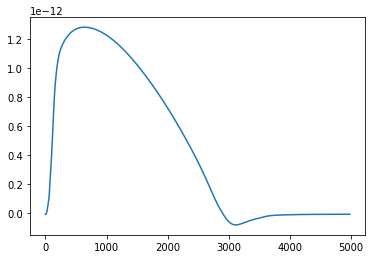

In [28]:
plt.plot(field.loops[0].time,foo[:,0])